In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

### Set Options

In [22]:
# Set whole=True if we want to analyze the new data and the old data together
whole = True

THRESHOLD = 80
batch_corrected = False
zero_remove = False
use_plsd_subset = True
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(zero_remove)+'_'+str(scaler_term)
test_enc_name_new = '_Whole_'+str(whole)+'_PlsdSubset_'+str(use_plsd_subset)

### Load Config Files

In [23]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

### Get Data

In [24]:
data_new = pd.read_excel(os.path.join(data_path,"2023_12_laezza_deltamethrin_metabolomics.xlsx"))
if whole:
    data_old = pd.read_excel(os.path.join(data_path,"2022_12_Laezza_Bernabucci_Mouse_Brain_COMBINED_METABOLOMICS.xlsx"))

#### -- We have to filter the old data extracting only males, striatum, PND30 --

In [25]:
if whole:
    data_old = data_old[data_old['Sample Submission Date'] == '11/2022']
    data_old = data_old[data_old['Sex']=='M']
    data_old = data_old[data_old['Tissue Type']=='striatum']
    data_old = data_old[data_old['PND']==30]

### Rename the columns

In [26]:
columns_data = ['LCMS Name', 'Tissue Weight\n(mg)', 'Treatment', 'Metabolite', 'Normalized Peak Area (Peak Area of Metabolite / (Peak Area of Internal Standard * Tissue weight))']
columns_old = ['Sample Name', 'Tissue weight\n(mg)', 'Treatment', 'Metabolite', 'Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))']
columns_new = ['name','weight','treatment','metabolite','area']

data_new = data_new[columns_data]
data_new.columns = columns_new
data_new['batch']=1

if whole:
    data_old = data_old[columns_old]
    data_old.columns = columns_new
    data_old['batch']=0

if whole:
    data_all = pd.concat([data_new, data_old], axis=0)
    data_all = data_all[data_all['area']!=0]
else:
    data_all = data_new.copy()
    
data_all['area'] = np.log(data_all['area'])

In [27]:
## number of samples

print(len(np.unique(data_all['name'])))

26


### Show some info (metabolites are less than the old data)

In [28]:
metabolites_list = data_all['metabolite'].nunique()
print(metabolites_list)

207


In [29]:
data_all.head()

,name,weight,treatment,metabolite,area,batch
0,Laezza #1,106,control,1 or 3-Methyl-Histidine.1,-4.538732,1
1,Laezza #2,82,control,1 or 3-Methyl-Histidine.1,-3.227442,1
2,Laezza #3,92,control,1 or 3-Methyl-Histidine.1,-4.773899,1
3,Laezza #4,105,control,1 or 3-Methyl-Histidine.1,-3.893745,1
4,Laezza #5,100,control,1 or 3-Methyl-Histidine.1,-4.290535,1


### Organize PIVOT Table

In [30]:
data_pivot = data_all.pivot(index=['name', 'treatment'], columns='metabolite', values=data_all.columns[-2])


data_pivot = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(1e-3*np.min(np.abs(data_all.iloc[:,-2])))

data_pivot['treatment'] = LabelEncoder().fit_transform(data_pivot['treatment'])
data_pivot.head()

metabolite,name,treatment,1 or 3-Methyl-Histidine.1,2'-O-Methyl Guanosine.1,2'-O-Methyl Uridine.1,2-Deoxycytide,2-Hydroxyglutarate.1,2-ketoglutaric acid.1,2/3-Phosphoglyceric acid.2,3-Hydroxyhexadecanoylcarnitine,...,UDP.1,Urate.1,Urea.1,Ureidosuccinic acid.1,Uridine.1,Xanthine.1,acetyl-CoA_pos,dGDP.1,glutathione disulfide_pos,sn-glycerol-3-phosphate.1
0,C15M1S,0,-6.027376,-10.244992,-8.857315,-6.008248,-3.915421,-6.913606,-8.419121,-6.256186,...,-7.175464,-7.003032,-2.167248,-4.458483,-3.072309,-4.245012,-6.731001,-4.609007,0.000001,-5.991207
1,C62M1S,0,-5.629738,-10.183447,-9.938186,-6.491512,-4.502041,-6.766981,-10.810593,-6.708994,...,-11.529038,-6.808951,-2.236118,-5.245530,-2.957595,-4.283107,-7.846362,-7.729930,-4.913726,-6.679960
2,C63M1S,0,-5.694237,-10.101875,-9.974555,-6.402515,-4.786079,-6.855724,-11.062538,-6.185396,...,-11.754332,-6.965191,-2.280404,-5.485073,-3.103059,-4.527706,-8.697023,-8.479288,-5.130358,-6.834526
3,Laezza #1,0,-4.538732,-9.991292,-10.530331,-7.504787,-4.180784,-2.848938,-4.611318,-6.407001,...,-5.530046,-7.779612,-3.304009,-4.259102,-4.486284,-4.862928,-5.926340,-3.370416,-1.282907,-5.668776
4,Laezza #10,0,-4.756983,-7.310499,-7.802734,-6.366854,-5.448672,-2.188969,-7.413345,-3.591153,...,-9.055753,-7.339957,-1.566261,-5.137251,-2.769198,-3.249870,-7.654659,-6.780270,-4.347206,-6.295892


In [31]:
metabolites_ok = list(data_pivot.columns[2:])
tot_metabolites = len(metabolites_ok)
tot_metabolites

131

### Dimensionality Reduction

In [32]:
from sklearn.cross_decomposition import PLSRegression

pls2_treatment = PLSRegression(n_components=26, scale = False)
pls2_date = PLSRegression(n_components=26, scale = False)
data_pls2_treatment = pls2_treatment.fit_transform(data_pivot.values[:,2:], data_pivot['treatment'].values)

c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cross_decomposition\_pls.py:302: UserWarning: Y residual is constant at iteration 25
  warnings.warn(f"Y residual is constant at iteration {k}")


In [33]:
p_values_pls2 = [
    [
        d,
        ttest_ind(data_pls2_treatment[0][data_pivot['treatment']==0, d], data_pls2_treatment[0][data_pivot['treatment']==1, d])[1],
    ]
    for d in range(data_pls2_treatment[0].shape[1])
]
p_values_pls2 = np.asarray(p_values_pls2)
print(p_values_pls2.shape)

(26, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


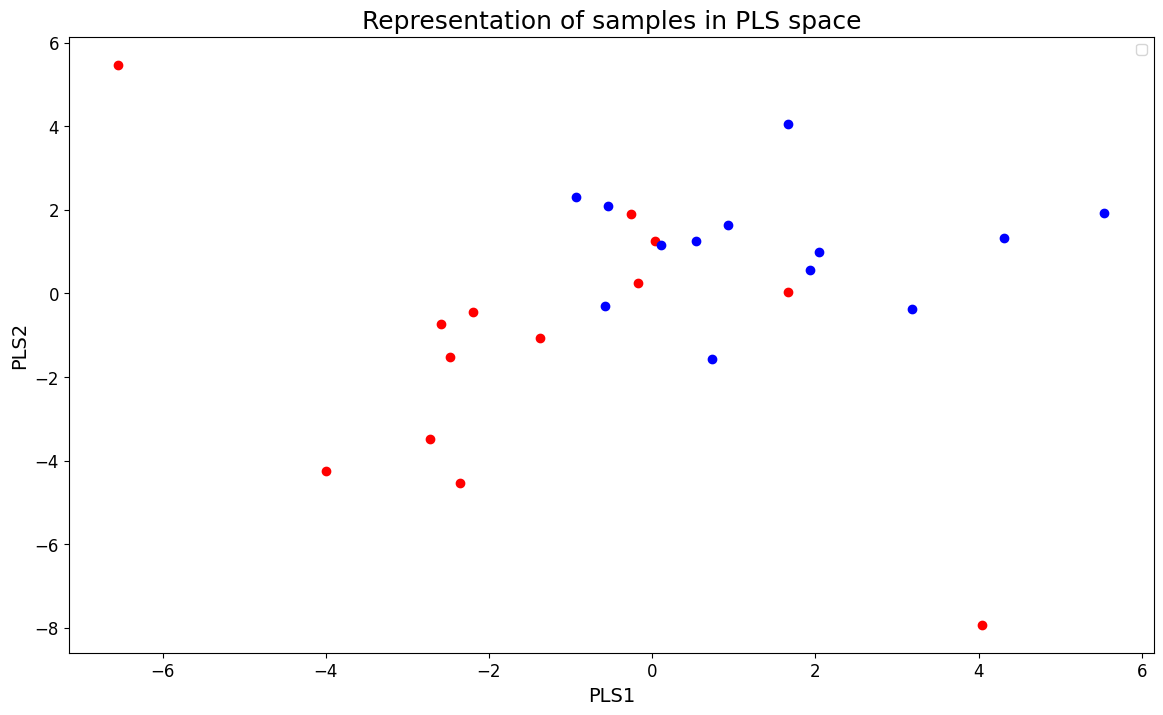

In [34]:
fig = plt.figure(figsize=(14,8))
plt.scatter(data_pls2_treatment[0][data_pivot['treatment']==0, 2], data_pls2_treatment[0][data_pivot['treatment']==0, 3],c="red")
plt.scatter(data_pls2_treatment[0][data_pivot['treatment']==1, 2], data_pls2_treatment[0][data_pivot['treatment']==1, 3],c="blue")
plt.legend()
plt.title('Representation of samples in PLS space', fontdict={'fontsize':18})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('PLS1', fontdict={'fontsize':14})
plt.ylabel('PLS2', fontdict={'fontsize':14})
fig.savefig(os.path.join(data_path,"mb-sample_distribution_PLS_space"+test_enc_name_new+".png"), format='png', facecolor='w', dpi=100)

In [35]:
print(f'{np.sum(p_values_pls2[:,1]<0.05)} significant pc with respect to TREATMENT')

significant_pc_pls2_treatment = np.where(p_values_pls2[:,1]<0.05)[0]
print(significant_pc_pls2_treatment)

2 significant pc with respect to TREATMENT
[2 3]


In [36]:
significant_components_pls2_treatment = pls2_treatment.x_weights_.T[significant_pc_pls2_treatment,:]
max_values_pls2_treatment = np.max(np.abs(significant_components_pls2_treatment), axis = 0)

In [37]:
ths_pls2_treatment = np.percentile(np.abs(pls2_treatment.x_weights_.T.flatten()), THRESHOLD)

In [38]:
tot_metabolites = data_pivot.shape[1] - 2

In [39]:
idx_significant_metabolites_pls2_treatment = np.where(max_values_pls2_treatment>ths_pls2_treatment)[0]
n_significant_metabolites_pls2_treatment = len(idx_significant_metabolites_pls2_treatment)
print(f'{n_significant_metabolites_pls2_treatment} ({n_significant_metabolites_pls2_treatment/tot_metabolites*100:.2f}% of original total) significant metabolites found')
significant_metabolites_pls2_treatment = [metabolites_ok[i] for i in idx_significant_metabolites_pls2_treatment]


55 (41.98% of original total) significant metabolites found


In [20]:
with open(os.path.join('results','significant_metabolites_pls2_treatment'+test_enc_name_new+'.txt'), 'w+') as f:
    for l in significant_metabolites_pls2_treatment:
        f.write(l+'\n')